In [8]:
import numpy as np
import matplotlib.pyplot as plt
from edes.utils.plotting import plot, plot_ax
from edes.utils.circuits import W_to_dBm, dBm_to_W, dB_to_frac, frac_to_dB, dB_to_Vfrac, Vfrac_to_dB
from edes.modules.detection.detection_utils import big_plt_font
from edes.modules.data_analysis.fitting_utils import plot_fitbounds, plot_fitbounds_ax
from edes.modules.data_analysis import fitting_functions as fitting 

big_plt_font()

In [3]:
def calc_Q(f0, f_left_3dB, f_right_3dB): 
    return f0 / (f_right_3dB - f_left_3dB)
    
def source_power_needed(V_elec, # 0-to-peak voltage needed at the electrode
    S21_left_base, S21_right_base, S21_min, # calculate power loss, S21 in [dB]
    Q, Z0_feedline, Z0_res, # to calculate voltage gain
    gain, attenuation): # total gain and attenuation by amplifiers and attenuators, in [dB]
    
    volt_boost = np.sqrt(Q*Z0_res / Z0_feedline)
    V_in = V_elec/volt_boost
    P_in = W_to_dBm(V_in**2/Z0_feedline/2) # P = Vrms^2/R = Vp^2/2R 
    S21_base = dB_to_Vfrac((S21_left_base+S21_right_base)/2)
    P_stored = frac_to_dB((S21_base - dB_to_Vfrac(S21_min))**2) # power stored by resonator
                                                                # P/Pin[dB] = 10log((V/Vin)^2)
    P_source = P_in - P_stored - gain - attenuation
    #print(P_in, P_stored)
    return P_source

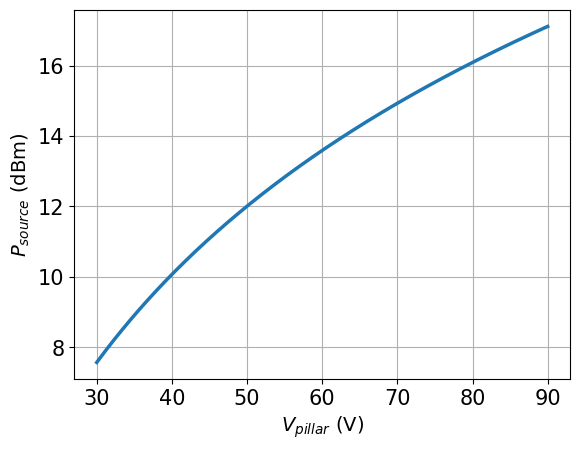

In [32]:
f0 = 1.4505
f_left_3dB = 1.435760 
f_right_3dB = 1.490656
V_elec = np.linspace(30, 90, 1000)
config = dict(
    Q = calc_Q(f0, f_left_3dB, f_right_3dB),
    S21_left_base = -4, 
    S21_right_base = -7, 
    S21_min = -11.30,
    Z0_feedline = 50, 
    Z0_res = 50, 
    gain = 44.5, 
    attenuation = -15
)

plot(V_elec, source_power_needed(V_elec, **config), xlabel=r'$V_{pillar}$ (V)', ylabel=r'$P_{source}$ (dBm)')

In [18]:
source_power_needed(60, **config)

31.343254683407032 -11.746948841341066


13.590203524748098

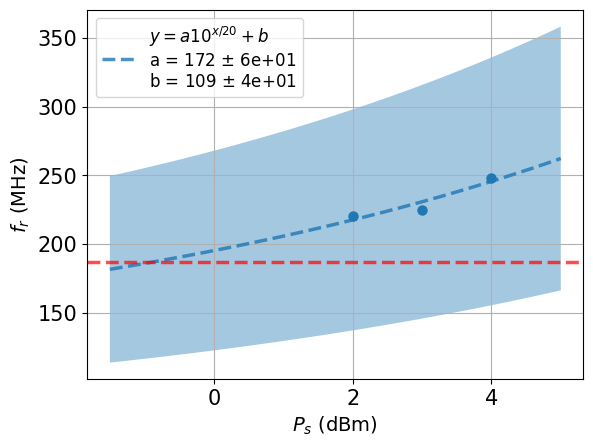

In [34]:
f_meas = np.array([248.3, 225.2, 220.6])
P_in = np.array([4, 3, 2])

class dBm_to_freq(fitting.fitting_function):
    def __init__(self):
        self.parameters = ['a', 'b']
        self.setup()
        
    def full_fun(self, x, a, b):
        return a*10*(x/20) + b
        
func = dBm_to_freq()
guess_params = {"a": 200, "b": 0
                }
func.set_guess_params(guess_params)
func.do_fit(10**(P_in/20), f_meas)

xfit = np.linspace(-1.5, 5, 100)
yfit = func.eval_with_fits(10**(xfit/20))
yT,yB = func.eval_with_bounds(10**(xfit/20))
func.get_fits()
fig, ax = plt.subplots()
plot_fitbounds_ax(ax, P_in, f_meas, xfit, yfit, yT,yB,func.get_fits(),
               xlabel=r'$P_s$ (dBm)', ylabel=r'$f_r$ (MHz)', fit_label=r'$y = a10^{x/20}+b$')
ax.axhline(187, linestyle='--', color='r', alpha=0.7)
plt.show()

In [33]:
xfit[np.argmin(abs(yfit-187))]

np.float64(-0.9090909090909091)